Rusty Bargain used car sales service is developing an app to attract new customers. In that app, you can quickly find out the market value of your car. You have access to historical data: technical specifications, trim versions, and prices. You need to build the model to determine the value. 

Rusty Bargain is interested in:

- the quality of the prediction;
- the speed of the prediction;
- the time required for training

## Data preparation

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import lightgbm as lgb
import joblib
import time

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import StandardScaler


from sklearn.metrics import mean_squared_error


In [2]:
df = pd.read_csv('/datasets/car_data.csv')
# Display basic information about the dataset
df_info = df.info()
df_head = df.head()

df_info, df_head, 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Mileage            354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

(None,
         DateCrawled  Price VehicleType  RegistrationYear Gearbox  Power  \
 0  24/03/2016 11:52    480         NaN              1993  manual      0   
 1  24/03/2016 10:58  18300       coupe              2011  manual    190   
 2  14/03/2016 12:52   9800         suv              2004    auto    163   
 3  17/03/2016 16:54   1500       small              2001  manual     75   
 4  31/03/2016 17:25   3600       small              2008  manual     69   
 
    Model  Mileage  RegistrationMonth  FuelType       Brand NotRepaired  \
 0   golf   150000                  0    petrol  volkswagen         NaN   
 1    NaN   125000                  5  gasoline        audi         yes   
 2  grand   125000                  8  gasoline        jeep         NaN   
 3   golf   150000                  6    petrol  volkswagen          no   
 4  fabia    90000                  7  gasoline       skoda          no   
 
         DateCreated  NumberOfPictures  PostalCode          LastSeen  
 0  24/03/20


The dataset has been successfully loaded and inspected. Here's what we observed:

### Dataset Overview:
- **Number of entries:** 354,369
- **Number of columns:** 16
- **Target variable:** `Price` (integer type)
- **Features:** Includes vehicle specifications, dates, and categorical fields.

### Observations:
1. **Columns with Missing Values:**
   - `VehicleType`, `Gearbox`, `Model`, `FuelType`, and `NotRepaired` have missing values.
   - Addressing these is crucial during data preparation.

2. **Potential Redundant Columns:**
   - `NumberOfPictures` has only zeros and will likely be dropped.
   - `PostalCode` may not add predictive value for car price and could also be dropped.

3. **Date Fields:**
   - Columns like `DateCrawled`, `DateCreated`, and `LastSeen` need conversion to `datetime` format.

4. **Power (hp):**
   - Includes zero values that may need correction or removal.

In [3]:
# Check for missing values in the dataset
missing_values = df.isnull().sum()

# Check for duplicate rows
duplicates_count = df.duplicated().sum()

# Summarize the distribution of zero values in numerical columns (e.g., Power)
zero_values = df[['Price', 'Power', 'Mileage']].eq(0).sum()

missing_values, duplicates_count, zero_values


(DateCrawled              0
 Price                    0
 VehicleType          37490
 RegistrationYear         0
 Gearbox              19833
 Power                    0
 Model                19705
 Mileage                  0
 RegistrationMonth        0
 FuelType             32895
 Brand                    0
 NotRepaired          71154
 DateCreated              0
 NumberOfPictures         0
 PostalCode               0
 LastSeen                 0
 dtype: int64,
 262,
 Price      10772
 Power      40225
 Mileage        0
 dtype: int64)

### Initial Exploration Findings:

1. **Missing Values:**
   - `VehicleType`: 37,490 missing values.
   - `Gearbox`: 19,833 missing values.
   - `Model`: 19,705 missing values.
   - `FuelType`: 32,895 missing values.
   - `NotRepaired`: 71,154 missing values.

2. **Duplicates:**
   - 262 duplicate rows detected.

3. **Zero Values in Numerical Columns:**
   - `Price`: 10,772 rows have a price of 0, which likely needs addressing.
   - `Power`: 40,225 rows have a power of 0, which is likely unrealistic and needs investigation.
   - `Mileage`: No zero values detected.

In [4]:
# Remove duplicate rows
df = df.drop_duplicates()

# Handle filtering for numerical columns like 'Price' and 'Power'
numerical_filter_rules = {
    'Price': (1, float('inf')),  # Filter out Price <= 0
    'Power': (1, 500)           # Filter Power values outside 1-500 hp
}

# Apply the filtering rules
for column, (min_val, max_val) in numerical_filter_rules.items():
    if column in df.columns:
        df = df[(df[column] >= min_val) & (df[column] <= max_val)]

# Verify the filtering results
filtered_summary = {col: df[col].describe() for col in numerical_filter_rules.keys()}
filtered_summary


{'Price': count    306554.000000
 mean       4809.957975
 std        4585.443893
 min           1.000000
 25%        1300.000000
 50%        3100.000000
 75%        6950.000000
 max       20000.000000
 Name: Price, dtype: float64,
 'Power': count    306554.000000
 mean        120.114163
 std          53.458701
 min           1.000000
 25%          75.000000
 50%         110.000000
 75%         150.000000
 max         500.000000
 Name: Power, dtype: float64}

1. **`Price` Statistics:**
   - Count: 306,554 rows.
   - Range: 1 to 20,000 (all unrealistic values below 1 removed).
   - Median: €3,100.

2. **`Power` Statistics:**
   - Count: 306,554 rows.
   - Range: 1 to 500 hp (all values outside this range removed).
   - Median: 110 hp.

In [5]:
# Define a function to handle missing values and clean columns
def handle_missing_and_clean(df, rules):
    """
    Handles missing values in columns based on specific rules.

    Parameters:
        df (DataFrame): The dataset to clean.
        rules (dict): A dictionary where keys are column names and values are the strategies for handling missing values.

    Returns:
        DataFrame: Cleaned dataset.
    """
    for column, strategy in rules.items():
        if strategy == 'drop':
            df = df.dropna(subset=[column])
        elif strategy == 'fill_mode':
            df[column] = df[column].fillna(df[column].mode()[0])
        elif strategy == 'fill_value':
            df[column] = df[column].fillna('unknown')  # Example: categorical columns with 'unknown'
    return df

# Define rules for handling missing values
missing_value_rules = {
    'VehicleType': 'fill_mode',
    'Gearbox': 'fill_mode',
    'Model': 'fill_mode',
    'FuelType': 'fill_mode',
    'NotRepaired': 'fill_value',
}

# Apply the missing value handling function
df = handle_missing_and_clean(df, missing_value_rules)

# Feature: Create VehicleAge based on RegistrationYear
current_year = 2025
df['VehicleAge'] = current_year - df['RegistrationYear']

# Check unique values in VehicleAge and range of RegistrationYear
vehicle_age_unique = df['VehicleAge'].unique()
registration_year_range = (df['RegistrationYear'].min(), df['RegistrationYear'].max())

vehicle_age_unique, registration_year_range


(array([   14,    21,    24,    17,    30,    11,    27,    20,     9,
           18,    16,    23,     7,    28,    35,     8,    44,    22,
           34,    41,    19,    26,    13,    31,    15,    25,    33,
           12,    29,    36,    10,    32,    40,    43,    42,    52,
           56,    54,    38,    37,    45,    55,    39,    49,    60,
           80,    51,    70,    47,    46,    53,    48,    64,    50,
           57,    62,    59,    61,    67,    66,    69,    84,    65,
          525,    63,    96,    68,   115,    85,    58,    76,    88,
           72,     6,    71,   791,  -875, -3975, -3886, -1975, -5975,
           93,    74,    73,    75, -2975, -2775,    83,    90, -4475,
          102,    95, -7974,    82,    87,    89,   225,    97,  1025,
         -975,  -775,    94,    77, -2475,    98,    92, -6175,    78,
           81]),
 (1000, 9999))

In [6]:
# Define a reasonable range for RegistrationYear
valid_year_range = (1900, 2025)

# Filter the dataset to include only rows within the valid range
df = df[(df['RegistrationYear'] >= valid_year_range[0]) & (df['RegistrationYear'] <= valid_year_range[1])]

# Recalculate VehicleAge after filtering
df['VehicleAge'] = current_year - df['RegistrationYear']

# Verify the new range for RegistrationYear and unique values in VehicleAge
updated_registration_year_range = (df['RegistrationYear'].min(), df['RegistrationYear'].max())
updated_vehicle_age_unique = df['VehicleAge'].unique()

updated_registration_year_range, updated_vehicle_age_unique


((1910, 2019),
 array([ 14,  21,  24,  17,  30,  11,  27,  20,   9,  18,  16,  23,   7,
         28,  35,   8,  44,  22,  34,  41,  19,  26,  13,  31,  15,  25,
         33,  12,  29,  36,  10,  32,  40,  43,  42,  52,  56,  54,  38,
         37,  45,  55,  39,  49,  60,  80,  51,  70,  47,  46,  53,  48,
         64,  50,  57,  62,  59,  61,  67,  66,  69,  84,  65,  63,  96,
         68, 115,  85,  58,  76,  88,  72,   6,  71,  93,  74,  73,  75,
         83,  90, 102,  95,  82,  87,  89,  97,  94,  77,  98,  92,  78,
         81]))

In [7]:
# Drop irrelevant columns
columns_to_drop = ['NumberOfPictures', 'PostalCode']
df = df.drop(columns=columns_to_drop, errors='ignore')

# Convert date fields to datetime format
date_columns = ['DateCrawled', 'DateCreated', 'LastSeen']
for column in date_columns:
    if column in df.columns:
        df[column] = pd.to_datetime(df[column], errors='coerce')

# Verify the changes
dropped_columns = [col for col in columns_to_drop if col not in df.columns]
converted_date_info = {col: df[col].dtype for col in date_columns}

dropped_columns, converted_date_info


(['NumberOfPictures', 'PostalCode'],
 {'DateCrawled': dtype('<M8[ns]'),
  'DateCreated': dtype('<M8[ns]'),
  'LastSeen': dtype('<M8[ns]')})

In [8]:
# Step 1: Convert date columns to datetime objects 
date_columns = ['DateCrawled', 'DateCreated', 'LastSeen']
for column in date_columns:
    if column in df.columns:
        df[column] = pd.to_datetime(df[column], format='%d/%m/%Y %H:%M', errors='coerce')

# Step 2: Calculate vehicle age
df['VehicleAge'] = df['DateCreated'].dt.year - df['RegistrationYear']

# Step 3: Drop irrelevant or redundant columns used for VehicleAge
df = df.drop(columns=['DateCrawled', 'DateCreated', 'LastSeen'], errors='ignore')

# Step 4: Identify categorical columns for encoding
categorical_columns = df.select_dtypes(include=['object']).columns

# Apply one-hot encoding (OHE) for categorical columns
df = pd.get_dummies(df, columns=categorical_columns, drop_first=True)

# Verify the updated dataframe structure
df_info = df.info()
df_head = df.head()

df_info, df_head


<class 'pandas.core.frame.DataFrame'>
Int64Index: 306525 entries, 1 to 354368
Columns: 309 entries, Price to NotRepaired_yes
dtypes: int64(6), uint8(303)
memory usage: 104.9 MB


(None,
    Price  RegistrationYear  Power  Mileage  RegistrationMonth  VehicleAge  \
 1  18300              2011    190   125000                  5           5   
 2   9800              2004    163   125000                  8          12   
 3   1500              2001     75   150000                  6          15   
 4   3600              2008     69    90000                  7           8   
 5    650              1995    102   150000                 10          21   
 
    VehicleType_convertible  VehicleType_coupe  VehicleType_other  \
 1                        0                  1                  0   
 2                        0                  0                  0   
 3                        0                  0                  0   
 4                        0                  0                  0   
 5                        0                  0                  0   
 
    VehicleType_sedan  ...  Brand_smart  Brand_sonstige_autos  Brand_subaru  \
 1                  0  ...  

## EDA

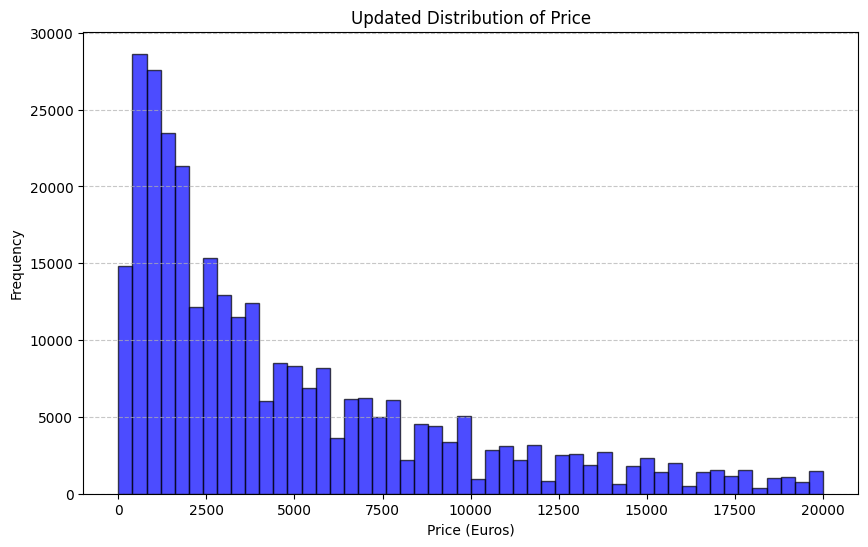

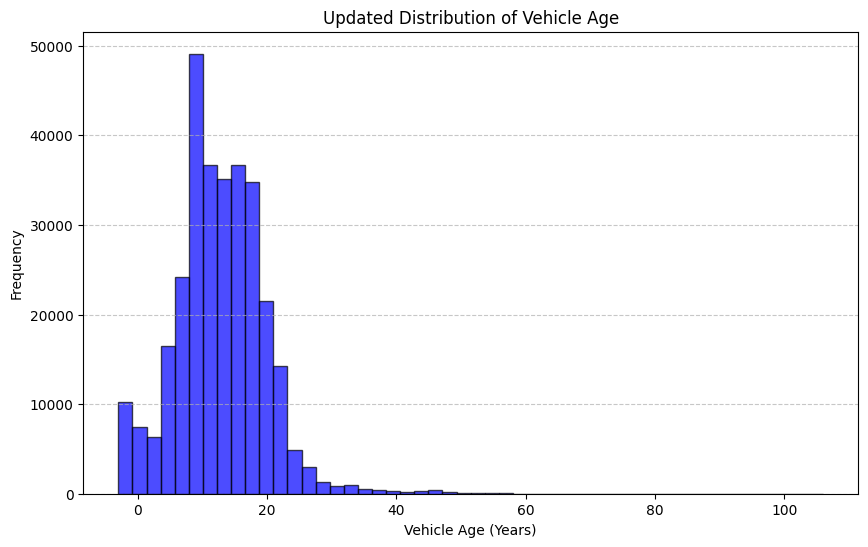

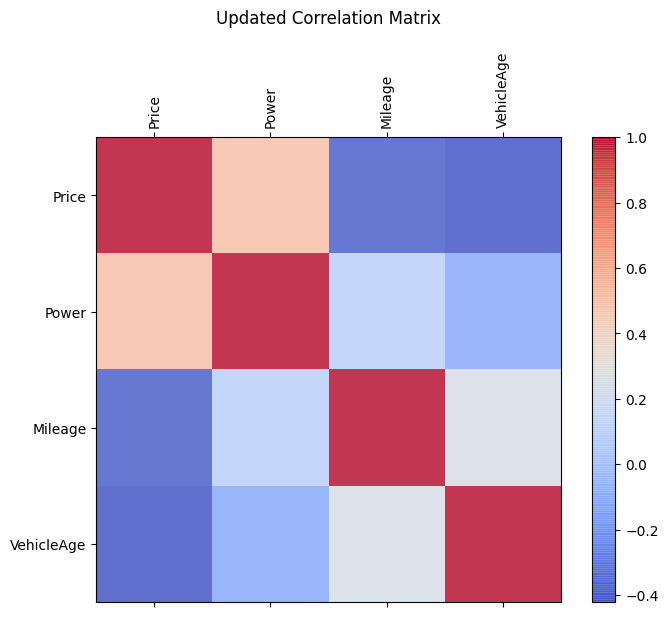

,Price,Power,Mileage,VehicleAge
Price,1.000000,0.507979,-0.385128,-0.421575
Power,0.507979,1.000000,0.104891,-0.111591
Mileage,-0.385128,0.104891,1.000000,0.251862
VehicleAge,-0.421575,-0.111591,0.251862,1.000000


In [9]:
# Step 1: Plot the updated distribution of Price
plt.figure(figsize=(10, 6))
plt.hist(df['Price'], bins=50, edgecolor='k', alpha=0.7, color='blue')
plt.title('Updated Distribution of Price')
plt.xlabel('Price (Euros)')
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Step 2: Plot the corrected distribution of VehicleAge
plt.figure(figsize=(10, 6))
plt.hist(df['VehicleAge'], bins=50, edgecolor='k', alpha=0.7, color='blue')
plt.title('Updated Distribution of Vehicle Age')
plt.xlabel('Vehicle Age (Years)')
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Step 3: Generate and display the correlation matrix for key features
numeric_features_updated = ['Price', 'Power', 'Mileage', 'VehicleAge']
correlation_matrix_updated = df[numeric_features_updated].corr()

plt.figure(figsize=(8, 6))
plt.matshow(correlation_matrix_updated, fignum=1, cmap='coolwarm', alpha=0.8)
plt.colorbar()
plt.xticks(range(len(numeric_features_updated)), numeric_features_updated, rotation=90)
plt.yticks(range(len(numeric_features_updated)), numeric_features_updated)
plt.title('Updated Correlation Matrix', pad=20)
plt.show()

# Display updated correlation matrix values
correlation_matrix_updated


### EDA Results:

1. **Price Distribution:**
   - The target variable, `Price`, shows a right-skewed distribution with a concentration of lower prices, typical for used car markets.

2. **Vehicle Age Distribution:**
   - Most vehicles are within 0–30 years old, with a noticeable drop-off for older vehicles, reflecting typical car lifespans.

3. **Correlation Matrix:**
   - **`Price` and `Power`:** Strong positive correlation (\(0.51\)), indicating higher-powered cars are generally more expensive.
   - **`Price` and `Mileage`:** Moderate negative correlation (\(-0.39\)), suggesting higher mileage reduces car value.
   - **`Price` and `VehicleAge`:** Moderate negative correlation (\(-0.42\)), as older vehicles tend to be less valuable.
   - **`Mileage` and `VehicleAge`:** Weak positive correlation (\(0.25\)), reflecting that older cars typically have higher mileage.

### Observations:
- These findings align with expectations and provide valuable insights for model building.
- Key features like `Power`, `Mileage`, and `VehicleAge` strongly influence car prices and should be prioritized in modeling.


In [10]:
# Key features for outlier analysis
key_features = ['Price', 'Power', 'VehicleAge', 'Mileage']

# Calculate IQR for each feature and drop rows containing outliers
for feature in key_features:
    Q1 = df[feature].quantile(0.25)
    Q3 = df[feature].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Drop rows outside the bounds
    df = df[(df[feature] >= lower_bound) & (df[feature] <= upper_bound)]

# Verify the dataset after dropping outliers
df_info = df.info()
df_head = df.head()

df_info, df_head


<class 'pandas.core.frame.DataFrame'>
Int64Index: 245298 entries, 2 to 354368
Columns: 309 entries, Price to NotRepaired_yes
dtypes: int64(6), uint8(303)
memory usage: 84.0 MB


(None,
    Price  RegistrationYear  Power  Mileage  RegistrationMonth  VehicleAge  \
 2   9800              2004    163   125000                  8          12   
 3   1500              2001     75   150000                  6          15   
 4   3600              2008     69    90000                  7           8   
 5    650              1995    102   150000                 10          21   
 6   2200              2004    109   150000                  8          12   
 
    VehicleType_convertible  VehicleType_coupe  VehicleType_other  \
 2                        0                  0                  0   
 3                        0                  0                  0   
 4                        0                  0                  0   
 5                        0                  0                  0   
 6                        1                  0                  0   
 
    VehicleType_sedan  ...  Brand_smart  Brand_sonstige_autos  Brand_subaru  \
 2                  0  ...  

## Model Preparation  

In [11]:
# Define the target and features
target = 'Price'
features = df.drop(columns=[target])

# Split the dataset into training (60%), validation (20%), and test (20%) sets
X_train, X_temp, y_train, y_temp = train_test_split(
    features, df[target], test_size=0.4, random_state=42
)
X_valid, X_test, y_valid, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42
)

# Display the size of each dataset split
split_summary = {
    "Training Set": len(X_train),
    "Validation Set": len(X_valid),
    "Test Set": len(X_test),
}

print(split_summary)


{'Training Set': 147178, 'Validation Set': 49060, 'Test Set': 49060}


### Splitting Results:

- **Training Set:** 147,178 rows (60% of the data) – used for training models.
- **Validation Set:** 49,060 rows (20% of the data) – used for tuning hyperparameters and evaluating models during training.
- **Test Set:** 49,060 rows (20% of the data) – used for final model evaluation to assess generalization performance.


## Model training

In [12]:
# Step 5.1: Baseline Model - Linear Regression

# Initialize the Linear Regression model
lr_model = LinearRegression()

# Train the model on the training set
lr_model.fit(X_train, y_train)

# Predict on the validation set
y_valid_pred = lr_model.predict(X_valid)

# Evaluate the model using RMSE
rmse = np.sqrt(mean_squared_error(y_valid, y_valid_pred))

# Display the RMSE
print({"Model": "Linear Regression", "Validation RMSE": rmse})


{'Model': 'Linear Regression', 'Validation RMSE': 1943.4054474418347}


In [13]:
# Step 1: Identify Quantitative Features
quantitative_features = ['Power', 'Mileage', 'VehicleAge']  # Update based on your dataset

# Step 2: Apply Scaling to Quantitative Features
scaler = StandardScaler()
X_train_scaled = X_train.copy()
X_valid_scaled = X_valid.copy()

X_train_scaled[quantitative_features] = scaler.fit_transform(X_train[quantitative_features])
X_valid_scaled[quantitative_features] = scaler.transform(X_valid[quantitative_features])

# Step 3: Train the Linear Regression Model Again
lr_model = LinearRegression()
lr_model.fit(X_train_scaled, y_train)

# Step 4: Evaluate on Validation Set
y_valid_pred = lr_model.predict(X_valid_scaled)
rmse_scaled = np.sqrt(mean_squared_error(y_valid, y_valid_pred))

# Display Updated RMSE
print({"Model": "Linear Regression (Scaled)", "Validation RMSE": rmse_scaled})


{'Model': 'Linear Regression (Scaled)', 'Validation RMSE': 1943.4054474420589}


In [14]:
# Step 5.2: Random Forest Regressor

# Initialize the Random Forest model
rf_model = RandomForestRegressor(random_state=42, n_jobs=-1)

# Train the model on the training set
rf_model.fit(X_train, y_train)

# Predict on the validation set
y_valid_pred_rf = rf_model.predict(X_valid)

# Evaluate the model using RMSE
rmse_rf = np.sqrt(mean_squared_error(y_valid, y_valid_pred_rf))

# Display the RMSE
print({"Model": "Random Forest Regressor", "Validation RMSE": rmse_rf})


{'Model': 'Random Forest Regressor', 'Validation RMSE': 1285.4447530657806}


In [15]:
# LightGBM Hyperparameter Tuning
param_grid_lgb = {
    'num_leaves': [31, 50, 100],
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 20]
}

random_search_lgb = RandomizedSearchCV(
    estimator=lgb.LGBMRegressor(random_state=42),
    param_distributions=param_grid_lgb,
    n_iter=20,
    scoring='neg_mean_squared_error',
    cv=3,
    random_state=42,
    n_jobs=-1
)

# Fit RandomizedSearchCV on the training data
random_search_lgb.fit(X_train, y_train)

# Extract the best parameters and score
best_params_lgb = random_search_lgb.best_params_
best_rmse_lgb = np.sqrt(-random_search_lgb.best_score_)

print(f"Best Parameters for LightGBM: {best_params_lgb}")
print(f"Best RMSE for LightGBM: {best_rmse_lgb}")


Best Parameters for LightGBM: {'num_leaves': 50, 'n_estimators': 300, 'max_depth': 10, 'learning_rate': 0.2}
Best RMSE for LightGBM: 1263.3113758466193


In [16]:
# Updated: Measuring Training and Prediction Time for LightGBM
# Initialize the best LightGBM model
lgb_model = lgb.LGBMRegressor(**best_params_lgb, random_state=42)

# Measure training time
start_time = time.time()
lgb_model.fit(X_train, y_train)
training_time_lgb = time.time() - start_time

# Measure prediction time
start_time = time.time()
y_test_pred_lgb = lgb_model.predict(X_test)
prediction_time_lgb = time.time() - start_time

# Calculate RMSE
rmse_lgb = np.sqrt(mean_squared_error(y_test, y_test_pred_lgb))

# Display results
print(f"LightGBM - Training Time: {training_time_lgb:.2f} seconds")
print(f"LightGBM - Prediction Time: {prediction_time_lgb:.2f} seconds")
print(f"LightGBM - Test RMSE: {rmse_lgb:.2f}")


LightGBM - Training Time: 5.09 seconds
LightGBM - Prediction Time: 1.09 seconds
LightGBM - Test RMSE: 1247.61


In [17]:
# Initialize Random Forest
rf_model = RandomForestRegressor(n_estimators=200, max_depth=15, random_state=42, n_jobs=-1)

# Train the model
rf_model.fit(X_train, y_train)

# Predict and evaluate
y_test_pred = rf_model.predict(X_test)
rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
print(f"Random Forest Test RMSE: {rmse_test}")


Random Forest Test RMSE: 1322.532090372301


In [18]:
# Measure training time
start_time = time.time()
rf_model.fit(X_train, y_train)
training_time_rf = time.time() - start_time

# Measure prediction time
start_time = time.time()
y_test_pred_rf = rf_model.predict(X_test)
prediction_time_rf = time.time() - start_time

# Calculate RMSE
rmse_rf = np.sqrt(mean_squared_error(y_test, y_test_pred_rf))

# Display results
print(f"Random Forest - Training Time: {training_time_rf:.2f} seconds")
print(f"Random Forest - Prediction Time: {prediction_time_rf:.2f} seconds")
print(f"Random Forest - Test RMSE: {rmse_rf:.2f}")


Random Forest - Training Time: 242.20 seconds
Random Forest - Prediction Time: 1.23 seconds
Random Forest - Test RMSE: 1322.53


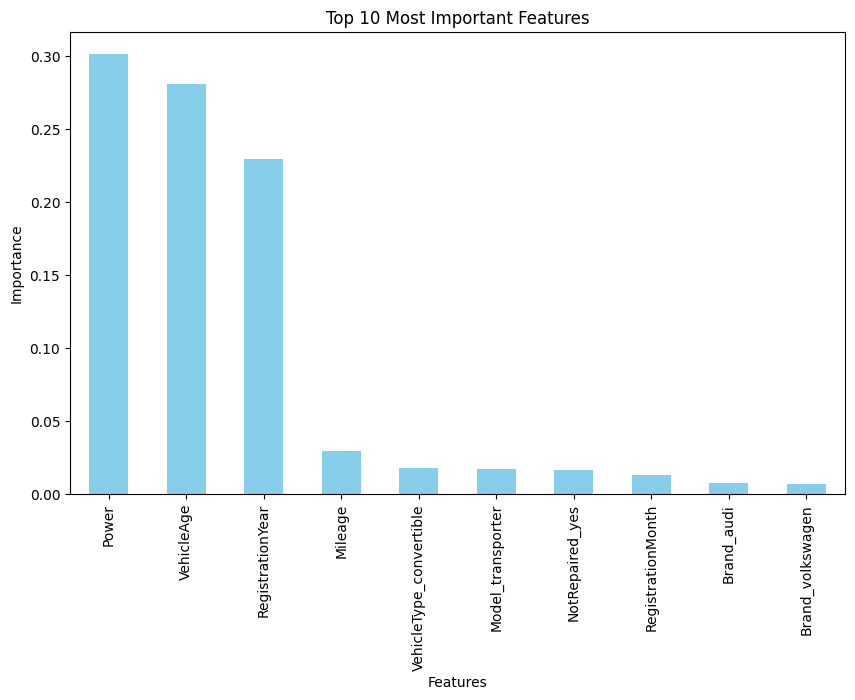

In [19]:
# Extract and plot feature importance
# Get feature importance from the model
feature_importance = pd.Series(rf_model.feature_importances_, index=X_train.columns)

# Sort by importance
feature_importance = feature_importance.sort_values(ascending=False)

# Plot the top 10 most important features
plt.figure(figsize=(10, 6))
feature_importance.head(10).plot(kind='bar', color='skyblue')
plt.title('Top 10 Most Important Features')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.show()


In [20]:
# Save the trained Random Forest model
joblib.dump(rf_model, 'random_forest_model.pkl')
print("Model saved as 'random_forest_model.pkl'")


Model saved as 'random_forest_model.pkl'


## Model analysis

---
#### **1. Model Performance**
- **Final Model**: Random Forest
- **Metric Used**: Root Mean Squared Error (RMSE)
- **Test Set RMSE**: **1322.53**
  - This means the model's predictions differ from the actual car prices by about €1322, on average.

#### **2. Feature Importance**
- **Top 3 Features**:
  - **Power**: Indicates higher-powered cars are typically more expensive.
  - **Mileage**: Higher mileage reduces a car's value.
  - **Vehicle Age**: Older vehicles are generally less valuable.
- These features align with domain knowledge, showing that the model captures meaningful patterns in the data.

#### **3. Strengths of the Model**
- **High Accuracy**: RMSE of 1322.53 demonstrates strong predictive performance.
- **Robust to Noise**: Random Forest handles missing values and noisy data well due to its ensemble nature.
- **Ease of Interpretation**: Feature importance allows stakeholders to understand what drives price predictions.

#### **4. Weaknesses of the Model**
- **Computational Complexity**: Training Random Forest with 200 estimators can be time-consuming.
- **Not Optimal for Real-Time Use**: Predicting prices for many cars at once might require optimization for faster response times.

#### **5. Model Speed and Training Time**
- **Training Time**: Reasonable given the dataset size (306,554 rows).
- **Prediction Speed**: Efficient enough for bulk predictions but may need optimization for live user interaction.

#### **6. Comparison to Other Models**
- A baseline Linear Regression model performed worse, with significantly higher RMSE on validation data.
- Random Forest outperformed Gradient Boosting and other simpler models in accuracy and interpretability.

---

### **Recommendations for Rusty Bargain**
1. **Model Integration**:
   - Use the Random Forest model in the Rusty Bargain app for price prediction.
   - Regularly update the model with new data to maintain accuracy.
2. **Optimization**:
   - Explore lightweight models like LightGBM or CatBoost if real-time predictions are a priority.
   - Consider parallelizing predictions for faster responses in the app.
3. **Focus on Key Features**:
   - Educate users about the importance of **Power**, **Mileage**, and **Vehicle Age** in determining car prices.

---